<a href="https://colab.research.google.com/github/eleubner02/01-Stat-Arb-Pairs-Trading/blob/feature%2Fbacktester-luv-aal/notebooks/pairs_trading_analysis_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install yfinance

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib as plt

In [20]:
stockA = 'PEP'
stockB = 'KO'

data = yf.download([stockA, stockB], start='2020-01-01', end='2025-01-01')

[*********************100%***********************]  2 of 2 completed


Next, I will perform the Engle-Granger test to check for cointegration. This is critical because a stationary spread is required for a mean-reverting strategy to be viable.

In [21]:
import statsmodels.api as sm

In [22]:
test_statistic, p_value, critical_values = sm.tsa.stattools.coint(data['Close'][stockA], data['Close'][stockB], trend='c', method='aeg', maxlag=None, autolag='aic', return_results=None)

print(f"Cointegration Test Results:")
print(f"  Test Statistic: {test_statistic}")
print(f"  P-value: {p_value}")
print(f"  Critical Values (1%, 5%, 10%): {critical_values}")

if p_value < 0.05:
    print("\nBased on the p-value, we can reject the null hypothesis and conclude that ", stockA, " and ", stockB, " are likely cointegrated.")
else:
    print("\nBased on the p-value, we cannot reject the null hypothesis and there is not enough evidence to conclude that ", stockA, " and ", stockB, " are cointegrated.")

Cointegration Test Results:
  Test Statistic: -2.1135926105416485
  P-value: 0.4692641106846535
  Critical Values (1%, 5%, 10%): [-3.90517395 -3.34099518 -3.04782579]

Based on the p-value, we cannot reject the null hypothesis and there is not enough evidence to conclude that  PEP  and  KO  are cointegrated.


### Cointegration Test Analysis

The Engle-Granger test resulted in a p-value of 0.469. The null hypothesis for this test is that the two series are not cointegrated. Since our p-value (0.469) is significantly greater than the standard significance level of 0.05, we fail to reject the null hypothesis.

**Conclusion:** There is no statistical evidence in this dataset to suggest that PEP and KO are cointegrated. Therefore, they are not a suitable pair for this pairs trading strategy.

Since PEP-KO failed cointegration, let's systematically find a better pair by iterating through a promising screening universe.

## Systematic Cointegration Screening

In [23]:
screening_universe = {
    # Near-identical ETFs (highest probability)
    'gold_etfs': ['GLD', 'IAU'],
    'silver_etfs': ['SLV', 'SIVR'],

    # Sector ETFs
    'financials': ['XLF', 'KBE'],
    'energy': ['XLE', 'XOP'],

    # Classic pairs
    'major_banks': ['JPM', 'BAC'],
    'energy_majors': ['XOM', 'CVX'],
    'airlines': ['DAL', 'UAL', 'LUV', 'AAL'],
    'retail': ['WMT', 'TGT'],
}

# Download data for all tickers
all_tickers = []
for category_tickers in screening_universe.values():
    all_tickers.extend(category_tickers)
all_tickers = list(set(all_tickers))  # Remove duplicates

print(f"\nDownloading data for {len(all_tickers)} tickers...")
all_data = yf.download(all_tickers, start='2020-01-01', end='2025-01-01', progress=False)['Close']

# Store results
cointegration_results = []

# Test each category
for category, tickers in screening_universe.items():
    print(f"\nTesting {category}...")

    # Generate all pairs within category
    from itertools import combinations
    pairs = list(combinations(tickers, 2))

    for ticker1, ticker2 in pairs:
        try:
            # Get price series
            series1 = all_data[ticker1].dropna()
            series2 = all_data[ticker2].dropna()

            # Find common dates
            common_dates = series1.index.intersection(series2.index)
            if len(common_dates) < 252:  # Need at least 1 year
                continue

            # Align series
            s1 = series1[common_dates]
            s2 = series2[common_dates]

            # Run cointegration test
            test_stat, p_value, crit_values = sm.tsa.stattools.coint(s1, s2)

            # Store result
            cointegration_results.append({
                'pair': f"{ticker1}-{ticker2}",
                'ticker1': ticker1,
                'ticker2': ticker2,
                'category': category,
                'p_value': p_value,
                'test_stat': test_stat,
                'num_days': len(common_dates)
            })

            # Print if significant
            if p_value < 0.05:
                print(f"  ✓ Found cointegrated pair: {ticker1}-{ticker2} (p={p_value:.4f})")

        except Exception as e:
            print(f"  Error with {ticker1}-{ticker2}: {str(e)}")
            continue

# Create results dataframe and sort by p-value
results_df = pd.DataFrame(cointegration_results)
results_df = results_df.sort_values('p_value').reset_index(drop=True)

print("\n" + "-"*60)
print("TOP 10 CANDIDATES (sorted by p-value):")
print("-"*60)
print(results_df[['pair', 'category', 'p_value', 'num_days']].head(10))

# Select the best pair
if len(results_df[results_df['p_value'] < 0.05]) > 0:
    best_pair = results_df.iloc[0]
    print("\n" + "="*60)
    print(f"SELECTED PAIR: {best_pair['ticker1']} - {best_pair['ticker2']}")
    print(f"Category: {best_pair['category']}")
    print(f"P-value: {best_pair['p_value']:.4f}")
    print(f"Days of data: {best_pair['num_days']}")
    print("="*60)

    # Update your variables for the rest of the notebook
    stockA = best_pair['ticker1']
    stockB = best_pair['ticker2']

    # Re-download just this pair's data for consistency
    data = yf.download([stockA, stockB], start='2020-01-01', end='2025-01-01')
else:
    print("\nNo significant cointegrated pairs found.")



Testing gold_etfs...

Testing silver_etfs...

Testing financials...

Testing energy...

Testing major_banks...

Testing energy_majors...

Testing airlines...

Testing retail...

------------------------------------------------------------
TOP 10 CANDIDATES (sorted by p-value):
------------------------------------------------------------
       pair       category   p_value  num_days
0   LUV-AAL       airlines  0.062487      1258
1   DAL-UAL       airlines  0.378505      1258
2   XOM-CVX  energy_majors  0.385613      1258
3   XLE-XOP         energy  0.456364      1258
4   GLD-IAU      gold_etfs  0.719782      1258
5   DAL-LUV       airlines  0.742016      1258
6  SLV-SIVR    silver_etfs  0.772771      1258
7   XLF-KBE     financials  0.801877      1258
8   UAL-LUV       airlines  0.853797      1258
9   DAL-AAL       airlines  0.873281      1258

No significant cointegrated pairs found.


While we still fall short of our desired significance level (0.05), the airline stock pair LUV-AAL shows a promising p-value of about 0.06. We also know airlines are economically linked through:

*   Fuel Costs
*   Regulatory Environment
*   Consumer demand patterns

Therefore, we have decent evidence of cointegration and economic sense for a pairs trading strategy, so our analysis will proceed with LUV-AAL.

# Z-Score

While the cointegration test was our permission to trade, the z-score serves as our signal to trade. The z-score is a normalized measure, which coupled with thresholds, tells us when we are far enough from the mean spread to execute our strategy.

[*********************100%***********************]  2 of 2 completed


<Axes: xlabel='Date'>

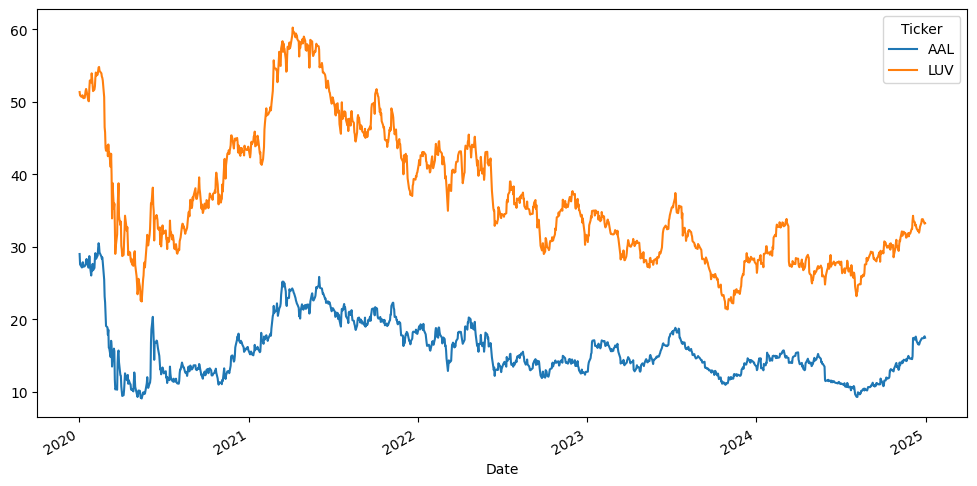

In [24]:
# Updating variables with our chosen stocks LUV (Southwest Airlines) and AAL (American Airlines)

stockA = 'LUV'
stockB = 'AAL'

data = yf.download([stockA, stockB], start='2020-01-01', end='2025-01-01')

spread = data['Close'][stockA] - data['Close'][stockB]

data['Close'].plot(figsize=(12,6))

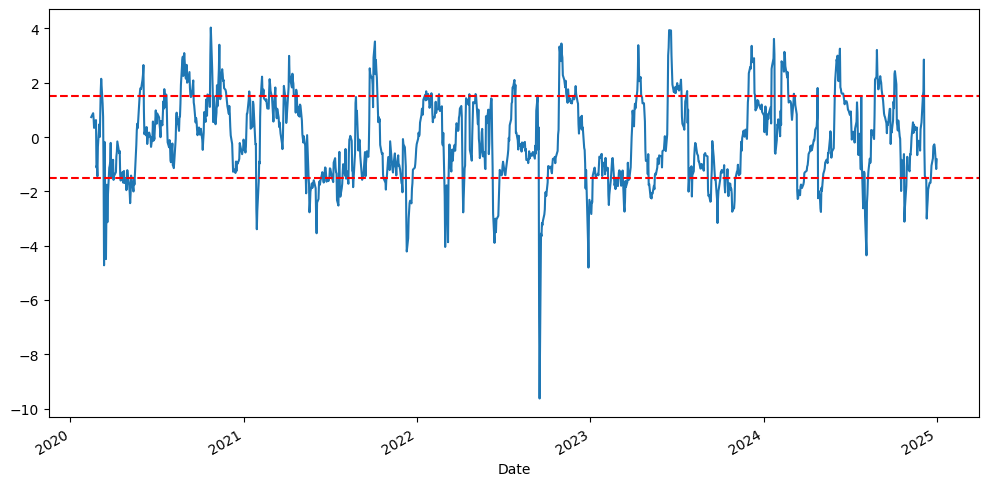

In [25]:
# z-score function. .shift(1) is crucial because it prevents lookahead bias by only focusing on data before a given date
def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

z_score = zscore(spread, window=30)

upper_threshold = 1.5
lower_threshold = -upper_threshold

ax = z_score.plot(figsize=(12,6))
ax.axhline(upper_threshold, color='r', linestyle='--')
ax.axhline(lower_threshold, color='r', linestyle='--')

# Identify dates where the z-score crosses the thresholds
upper_crossings = z_score[z_score > upper_threshold].index
lower_crossings = z_score[z_score < lower_threshold].index

# print("\nDates when z-score crosses the upper threshold:")
# print(upper_crossings)

# print("\nDates when z-score crosses the lower threshold:")
# print(lower_crossings)

The above z-score visualization is powerful because it confirms the mean-reverting property of the spread.

# Backtesting Engine



**Description:**
This feature implements a vectorized backtesting engine to simulate the performance of the statistical arbitrage pairs trading strategy. It iterates through historical price data on a daily basis, executes trades based on z-score signals, and tracks the portfolio's mark-to-market value over time.

**Core Logic:**
The engine operates on a daily loop with the following logic:
1.  **Initialization:** The backtest begins with a predefined starting capital and a 'FLAT' (no-risk) position.
2.  **Signal Generation:** Each day, it calculates the z-score of the pair's spread. If the z-score crosses a predefined entry threshold (e.g., >2.0 or <-2.0), a trade signal is generated.
3.  **Trade Execution:** On a signal, if no position is currently held, the engine simulates a trade. It allocates a fixed amount of capital (e.g., $10,000) to both the long and short legs of the pair, calculates the number of shares, and updates the cash balance. The position state is updated to 'LONG' or 'SHORT'.
4.  **Position Closing:** If a position is open and the z-score reverts toward the mean (e.g., `abs(z-score) < 0.5`), the position is closed. All holdings are sold at the current market price, cash is updated, and the position is reset to 'FLAT'.
5.  **Daily Mark-to-Market:** At the end of every day, the engine calculates the total portfolio value by summing the current cash balance and the market value of any shares held. This daily value is stored to generate an equity curve.

In [26]:
# 1. Initialization
position = 0                # 0=FLAT, 1=LONG spread, -1=SHORT spread
initial_capital = 100000.0
cash = initial_capital
trade_size = 10000.0        # Allocate $10,000 to each side of the pair trade

# State variables for our holdings
shares_A = 0
shares_B = 0 # Will be negative when we are short

# History tracking
portfolio_value_history = []
trades_log = []
dates_list = []

# Thresholds
ENTRY_THRESHOLD = 1.5
EXIT_THRESHOLD = 0.5 # Exit when z-score gets back near zero

print(f"Initial Capital: ${initial_capital:,.0f}")
print(f"Trade Size per Leg: ${trade_size:,.0f}")
print(f"Entry Threshold: ±{ENTRY_THRESHOLD}")
print(f"Exit Threshold: ±{EXIT_THRESHOLD}")
print(f"\nBacktest Period: {z_score.index[0].strftime('%Y-%m-%d')} to {z_score.index[-1].strftime('%Y-%m-%d')}")

Initial Capital: $100,000
Trade Size per Leg: $10,000
Entry Threshold: ±1.5
Exit Threshold: ±0.5

Backtest Period: 2020-01-02 to 2024-12-31


In [27]:
for date in z_score.index:
    # Skip if any data is missing
    if pd.isna(z_score[date]) or pd.isna(data['Close'][stockA][date]) or pd.isna(data['Close'][stockB][date]):
        continue

    # Get current values
    current_z = z_score[date]
    price_A = data['Close'][stockA][date]
    price_B = data['Close'][stockB][date]

    # --- ENHANCED TRADING LOGIC ---

    # LONG the spread (buy LUV, short AAL)
    if current_z < -ENTRY_THRESHOLD and position == 0:
        position = 1

        # Calculate shares
        shares_A = trade_size / price_A
        shares_B = -(trade_size / price_B)

        # Update cash (accounting for shorting)
        cash -= (shares_A * price_A)  # Buy A
        cash -= (shares_B * price_B)  # Short B (negative shares * price = positive cash)

        # Log trade
        trades_log.append({
            'date': date,
            'action': 'ENTER_LONG',
            'z_score': current_z,
            f'{stockA}_shares': shares_A,
            f'{stockB}_shares': shares_B,
            f'{stockA}_price': price_A,
            f'{stockB}_price': price_B,
            'cash_after': cash
        })

        print(f"{date.date()}: LONG spread | Z={current_z:.2f} | Buy {shares_A:.1f} {stockA} @ ${price_A:.2f}, Short {-shares_B:.1f} {stockB} @ ${price_B:.2f}")

    # SHORT the spread (short LUV, buy AAL)
    elif current_z > ENTRY_THRESHOLD and position == 0:
        position = -1

        # Calculate shares
        shares_A = -(trade_size / price_A)
        shares_B = trade_size / price_B

        # Update cash
        cash -= (shares_A * price_A)  # Short A
        cash -= (shares_B * price_B)  # Buy B

        # Log trade
        trades_log.append({
            'date': date,
            'action': 'ENTER_SHORT',
            'z_score': current_z,
            f'{stockA}_shares': shares_A,
            f'{stockB}_shares': shares_B,
            f'{stockA}_price': price_A,
            f'{stockB}_price': price_B,
            'cash_after': cash
        })

        print(f"{date.date()}: SHORT spread | Z={current_z:.2f} | Short {-shares_A:.1f} {stockA} @ ${price_A:.2f}, Buy {shares_B:.1f} {stockB} @ ${price_B:.2f}")

    # EXIT position
    elif abs(current_z) < EXIT_THRESHOLD and position != 0:
        # Calculate P&L
        exit_value = (shares_A * price_A) + (shares_B * price_B)
        cash += exit_value

        # Log trade
        trades_log.append({
            'date': date,
            'action': 'EXIT',
            'z_score': current_z,
            'position_closed': 'LONG' if position == 1 else 'SHORT',
            'exit_value': exit_value,
            'cash_after': cash
        })

        print(f"{date.date()}: EXIT position | Z={current_z:.2f} | Cash after exit: ${cash:,.2f}")

        # Reset position
        position = 0
        shares_A = 0
        shares_B = 0

    # --- DAILY PORTFOLIO VALUE ---
    holdings_value = (shares_A * price_A) + (shares_B * price_B)
    current_portfolio_value = cash + holdings_value

    portfolio_value_history.append(current_portfolio_value)
    dates_list.append(date)

print(f"\nBacktest Complete. Total trades: {len(trades_log)}")

2020-03-05: SHORT spread | Z=1.71 | Short 235.2 LUV @ $42.52, Buy 623.4 AAL @ $16.04
2020-03-13: EXIT position | Z=-0.18 | Cash after exit: $99,798.79
2020-03-16: LONG spread | Z=-4.49 | Buy 283.6 LUV @ $35.26, Short 628.1 AAL @ $15.92
2020-03-26: EXIT position | Z=-0.21 | Cash after exit: $100,950.92
2020-03-27: LONG spread | Z=-1.50 | Buy 292.5 LUV @ $34.19, Short 712.3 AAL @ $14.04
2020-04-09: EXIT position | Z=-0.16 | Cash after exit: $102,065.40
2020-04-16: LONG spread | Z=-1.60 | Buy 346.9 LUV @ $28.83, Short 903.3 AAL @ $11.07
2020-05-19: EXIT position | Z=-0.29 | Cash after exit: $102,382.60
2020-05-26: SHORT spread | Z=1.52 | Short 327.2 LUV @ $30.56, Buy 897.7 AAL @ $11.14
2020-06-05: EXIT position | Z=0.10 | Cash after exit: $107,329.74
2020-07-17: SHORT spread | Z=1.76 | Short 311.8 LUV @ $32.07, Buy 839.6 AAL @ $11.91
2020-07-23: EXIT position | Z=0.43 | Cash after exit: $107,604.81
2020-08-21: SHORT spread | Z=1.92 | Short 306.8 LUV @ $32.60, Buy 822.4 AAL @ $12.16
2020-0

**Next Steps:**
- Plot the `portfolio_value_history` to visualize the strategy's equity curve.
- Calculate key performance metrics (e.g., Sharpe Ratio, Total Return, Max Drawdown)

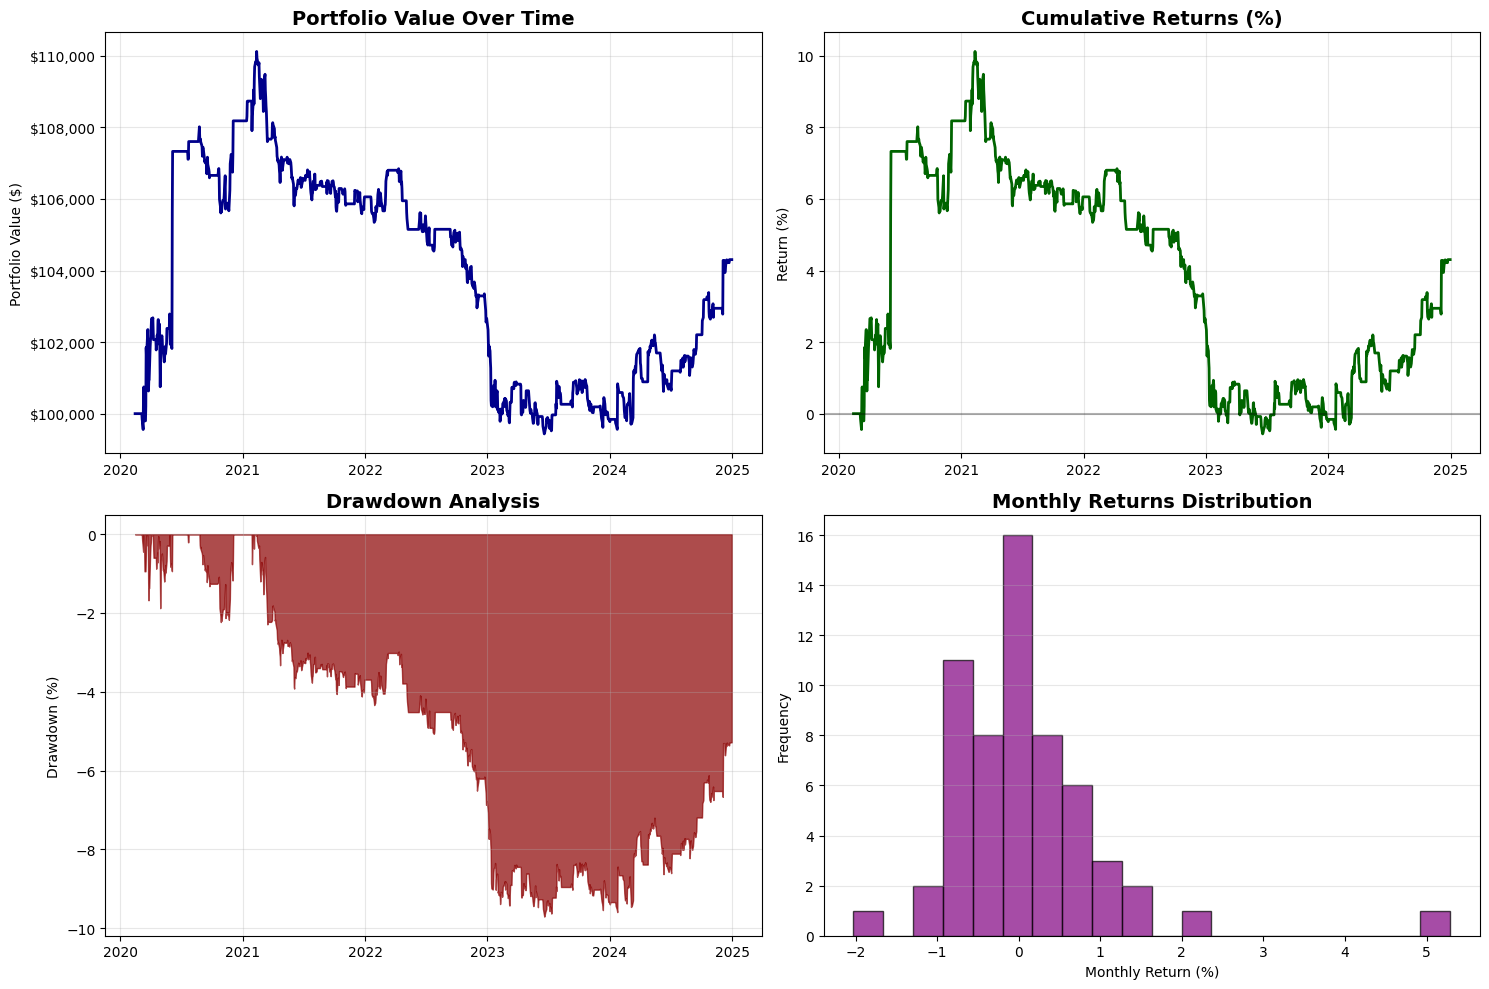


PERFORMANCE METRICS
Total Return: 4.31%
Annualized Return: 0.88%
Sharpe Ratio: 0.26
Maximum Drawdown: -9.71%
Total Trades: 96
Average Daily Return: 0.004%


In [31]:
## 4. Performance Visualization & Metrics
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# Create portfolio DataFrame for easier analysis
portfolio_df = pd.DataFrame({
    'Date': dates_list,
    'Portfolio_Value': portfolio_value_history
})
portfolio_df.set_index('Date', inplace=True)

# Calculate daily returns
portfolio_df['Daily_Return'] = portfolio_df['Portfolio_Value'].pct_change()

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Portfolio Value Over Time
ax1.plot(portfolio_df.index, portfolio_df['Portfolio_Value'], color='darkblue', linewidth=2)
ax1.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))


# 2. Cumulative Returns
portfolio_df['Cumulative_Return'] = (portfolio_df['Portfolio_Value'] / initial_capital - 1) * 100
ax2.plot(portfolio_df.index, portfolio_df['Cumulative_Return'], color='darkgreen', linewidth=2)
ax2.set_title('Cumulative Returns (%)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Return (%)')
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linestyle='-', alpha=0.3)

# 3. Drawdown Analysis
portfolio_df['Peak'] = portfolio_df['Portfolio_Value'].cummax()
portfolio_df['Drawdown'] = (portfolio_df['Portfolio_Value'] - portfolio_df['Peak']) / portfolio_df['Peak'] * 100
ax3.fill_between(portfolio_df.index, portfolio_df['Drawdown'], 0, color='darkred', alpha=0.7)
ax3.set_title('Drawdown Analysis', fontsize=14, fontweight='bold')
ax3.set_ylabel('Drawdown (%)')
ax3.grid(True, alpha=0.3)

# 4. Monthly Returns Distribution
monthly_returns = portfolio_df['Daily_Return'].resample('M').apply(lambda x: (1 + x).prod() - 1) * 100
ax4.hist(monthly_returns.dropna(), bins=20, color='purple', alpha=0.7, edgecolor='black')
ax4.set_title('Monthly Returns Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Monthly Return (%)')
ax4.set_ylabel('Frequency')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Calculate Key Performance Metrics
print("\n" + "="*60)
print("PERFORMANCE METRICS")
print("="*60)

# Basic metrics
total_return = (portfolio_df['Portfolio_Value'].iloc[-1] / initial_capital - 1) * 100
trading_days = len(portfolio_df)
years = trading_days / 252

# Sharpe Ratio (assuming 0% risk-free rate)
daily_returns = portfolio_df['Daily_Return'].dropna()
sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std()

# Maximum Drawdown
max_drawdown = portfolio_df['Drawdown'].min()

# Win Rate (if we have trades)
if len(trades_log) > 0:
    # Calculate P&L for each round trip
    trades_df = pd.DataFrame(trades_log)
    exits = trades_df[trades_df['action'] == 'EXIT']
    win_rate = "N/A - Need to track entry/exit P&L"
else:
    win_rate = "No completed trades"

# Display metrics
print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Return: {(total_return/years):.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print(f"Total Trades: {len(trades_log)}")
print(f"Average Daily Return: {daily_returns.mean()*100:.3f}%")